In [1]:
options(here.quiet = TRUE)
library(tidyverse)
library(survival)
library(survminer)
library(here)

── Attaching core tidyverse packages ──── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


here() starts at /diskmnt/Projects/Users/ysong/project/jupyter_lab/MMRF_analysis/IA2024Paper1/Fig1/scripts



In [2]:
df <-read.delim("../data/baseline_263_visit_clinical.txt")
# Format the categorical variable to appropriate factor levels.
df <- df %>%
  mutate(
    Sex = d_pt_sex,
    Age = d_dx_amm_age,
    BMI = d_dx_amm_bmi,
    Transplant = d_amm_tx_asct_1st,
    PFS = censpfs,
    PFS.time = ttcpfs,
    OS = censos,
    OS.time = ttcos,
    Treatment = case_when(
      d_tx_induction_cat == "chemo_imid_pi_steroid" ~ "imid_pi_steroid",
      d_tx_induction_cat == "chemo_pi_steroid" ~ "pi_steroid",
      TRUE ~ d_tx_induction_cat
    ),
    risk = case_when(
      davies_based_risk %in% c("no_risk_data", "not_calculable") ~ NA_character_,
      TRUE ~ as.character(davies_based_risk)
    ),
    ECOG = case_when(
      d_dx_amm_ecog %in% c("3", "4") ~ ">=3",
      TRUE ~ as.character(d_dx_amm_ecog)
    ),
    Race = case_when(
      d_pt_race_1 %in% c("asian_nos", "unknown") ~ "others/unknown",
      d_pt_race_1 %in% c("black_african_american") ~ "black",
      TRUE ~ as.character(d_pt_race_1)
    ),
    ISS_stage = case_when(
      d_dx_amm_iss_stage %in% c("1") ~ "stage I",
      d_dx_amm_iss_stage %in% c("2") ~ "stage II",
      d_dx_amm_iss_stage %in% c("3") ~ "stage III",
      TRUE ~ as.character(d_dx_amm_iss_stage)
    )
  ) %>%
  mutate(
    Treatment = factor(Treatment, levels = c("pi_steroid", "imid_pi_steroid", "imid_steroid")),
    risk = factor(risk, levels = c("standard_risk", "high_risk")),
    ECOG = factor(ECOG, levels = c("0", "1", "2", ">=3")),
    Race = factor(Race, levels = c("white", "black", "others/unknown")),
    ISS_stage = factor(ISS_stage, levels = c("stage I", "stage II", "stage III"))
  )

# Display the first few rows of the transformed data frame
df %>%
  select(Sex, BMI, Transplant, Treatment, risk, ECOG, Race, ISS_stage)%>% head()

,Sex,BMI,Transplant,Treatment,risk,ECOG,Race,ISS_stage
,<chr>,<dbl>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>
1,male,31.20,no,pi_steroid,high_risk,0,white,stage III
2,male,24.26,no,imid_pi_steroid,NA,1,white,stage I
3,male,25.21,yes,imid_pi_steroid,high_risk,1,white,stage II
4,female,33.12,no,pi_steroid,NA,2,white,NA
5,male,42.78,no,imid_pi_steroid,high_risk,1,white,stage II
6,male,25.73,yes,imid_pi_steroid,standard_risk,0,white,stage II


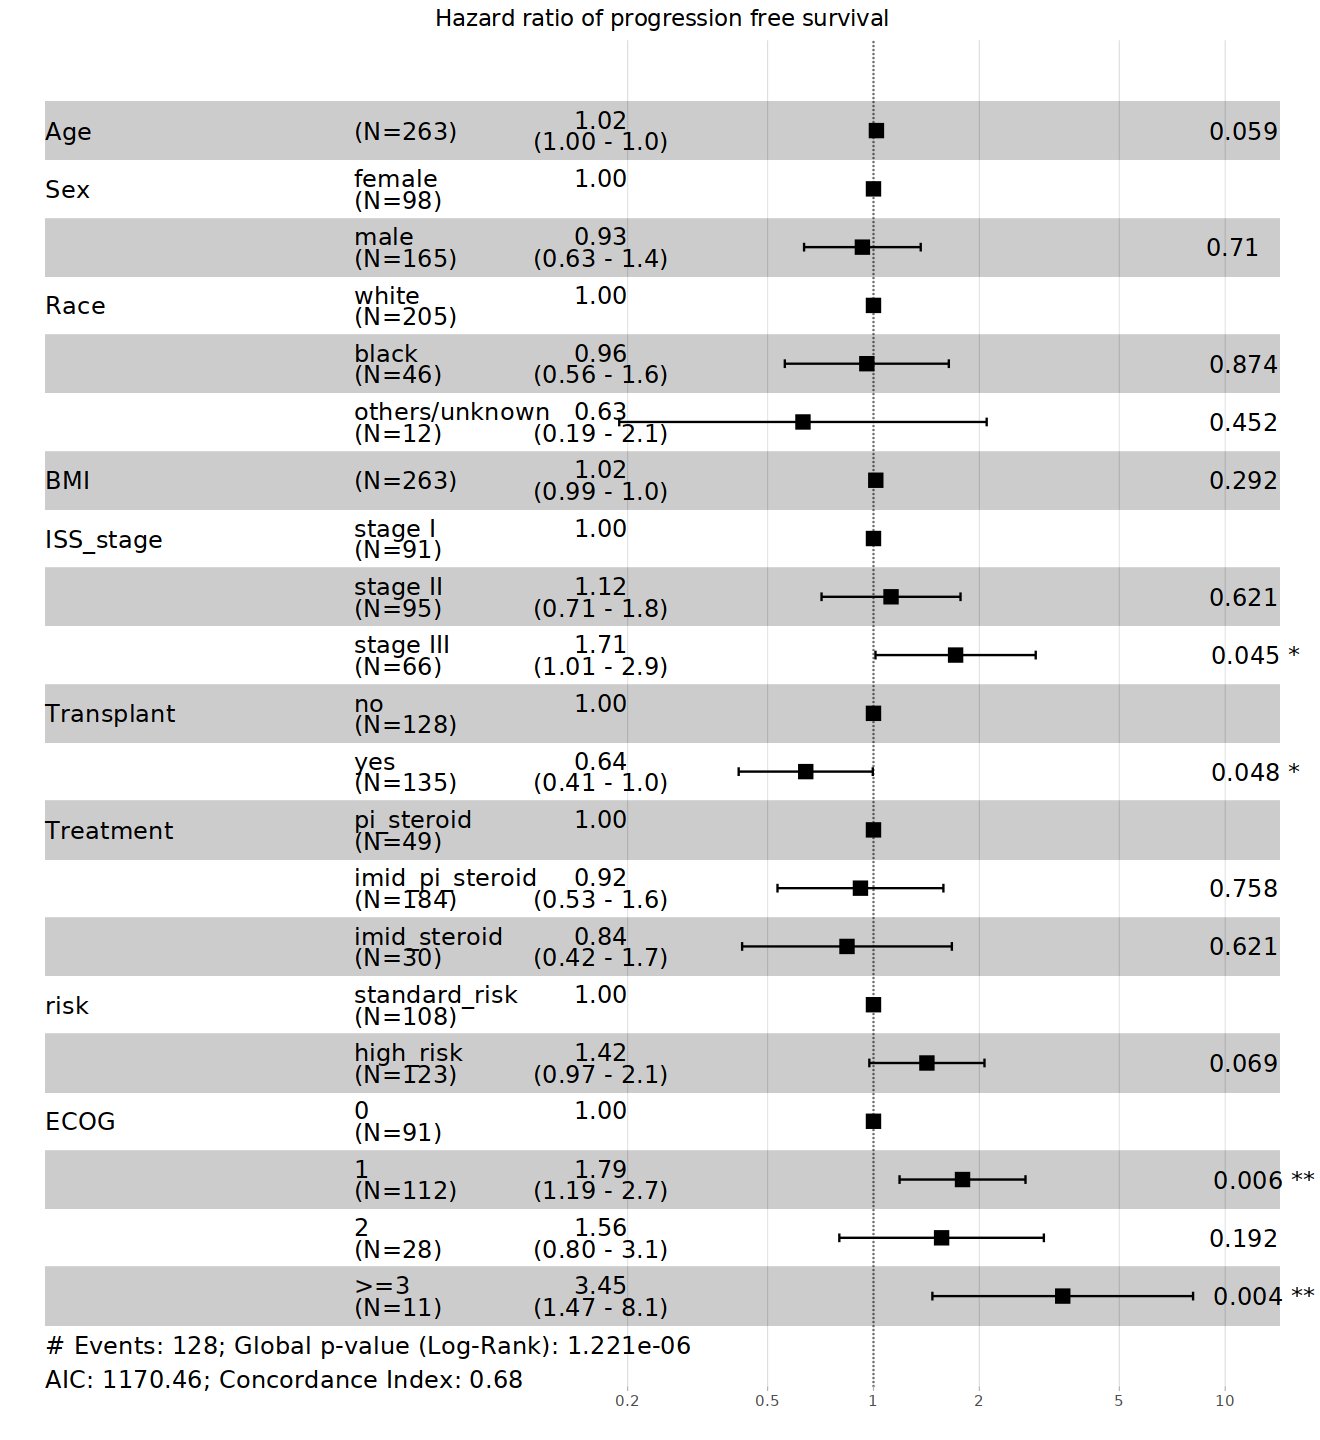

In [3]:
# Figure 1B Hazard Ratio of clinical features associated with PFS
options(repr.plot.width=11, repr.plot.height=12)

formula <- as.formula(paste("Surv(PFS.time, PFS) ~", "Age +Sex+ Race+ BMI +ISS_stage + Transplant +Treatment+risk+ECOG"))
model <- coxph(formula, data = as.data.frame(df))
p <- ggforest(model, data = as.data.frame(df),
              main = 'Hazard ratio of progression free survival', 
              cpositions = c(0.0, 0.25, 0.45),
              fontsize = 1.3,
              refLabel = '1.00',
              noDigits = 2)

p